In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
!mkdir content/

In [3]:
pwd

'/content'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
asana_dict = {}

In [6]:
def scale_transform_normalize(coords):
    """
    Parameters:
    coords (ndarray): array of (x,y,z,v) coordinates

    Returns:
    ndarray: coords scaled to 1x1 with center at (0,0)
    ndarray: confidence scores of each joint
    """
    coords, scores = coords[:,:,:-1], coords[:,:,-1]
    diff = coords.max(axis=1) - coords.min(axis=1)
    diff_max = np.max(diff, axis=0)
    mean = coords.mean(axis=1).reshape(coords.shape[0],1,coords.shape[-1])
    out = (coords - mean) / diff_max
    
    return out, scores

In [7]:
def balanced_pairs(X_data,y_data,name=''):
  N = y_data.shape[0]
  X = []
  # Prepare y
  y = []
  # Grab every possible combination of 2 rows
  for index in tqdm(combinations(np.arange(N), 2)):
    vec_1 = X_data[index[0]]
    vec_2 = X_data[index[1]]
    X.append(np.concatenate([vec_1, vec_2]).flatten())
    y.append(int(y_data[index[0]] == y_data[index[1]]))
  
  X = np.array(X)
  y = np.array(y)
  trues = X[y == 1]
  falses = X[y == 0]
  small_falses = resample(falses, n_samples=trues.shape[0])

  balanced_X = np.concatenate([trues, small_falses])
  balanced_y = np.concatenate([np.ones((trues.shape[0],)), np.zeros((trues.shape[0]))])

  np.save('/content/drive/MyDrive/content/dataset/'+name+'X', balanced_X)
  balanced_X = None
  np.save('/content/drive/MyDrive/content/dataset/'+name+'y', balanced_y)
  balanced_y = None

  return 

In [8]:
len(os.listdir("/content/drive/MyDrive/Yoga-Posture-Matching/Dataset/Yoga-82/yoga_dataset_links/Keypoints"))

77

In [9]:
def preprocess(kp_folder="/content/drive/MyDrive/Yoga-Posture-Matching/Dataset/Yoga-82/yoga_dataset_links/Keypoints", start =0, end =76, split = True):
  # Read all npy files
  global asana_dict
  X_data = []
  y_data = []
  dir_list = os.listdir(kp_folder)[start:end]
  k = 0
  for f in os.scandir("/content/drive/MyDrive/Yoga-Posture-Matching/Dataset/Yoga-82/yoga_dataset_links/Keypoints"):
      if f.is_file() and f.name != '.DS_Store' and f.name in dir_list:
          x = np.load(f)
          
          # Remove empty coords
          #x = [coords for coords in x if 4 in coords.shape]
          #x = np.concatenate(x)
          X_data.append(x)
          y_data.extend([k]*x.shape[0])
          asana_dict[k] = f.name
          k += 1

  X_data = np.concatenate(X_data)
  #X_data = np.array(X_data)
  y_data = np.array(y_data)

  # Sanity check
  print("X_data shape: {}".format(X_data.shape))
  print("y_data shape: {}".format(y_data.shape))

  N,D,C = X_data.shape
  
  # Prepare X
  X_norm, scores = scale_transform_normalize(X_data)


  scores = scores.reshape((N, D, 1))


  X_data = np.concatenate([X_norm, scores], axis=2)
  X_data /= np.linalg.norm(X_data, axis=2)[:, :, np.newaxis]

  if split:
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=1)
    balanced_pairs(X_train, y_train, 'train')
    balanced_pairs(X_test, y_test, 'test')
  else:
    balanced_pairs(X_data, y_data)


  return 


In [10]:
preprocess() #generates pairwise training data according to args given. 

X_data shape: (3456, 33, 4)
y_data shape: (3456,)


2147628it [00:15, 140518.24it/s]
955653it [00:09, 96831.09it/s]


**STOP HERE**

Restart Kernel if need be

**Training on genereted pair-wise data**
Task : classify if the pair contains same asanas or different.

In [11]:
import numpy as np

In [12]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.callbacks import CSVLogger

In [13]:
#%cd /content/drive/MyDrive/Yoga-82/yoga_dataset_links/Final_dataset

In [14]:
X_train = np.load("/content/drive/MyDrive/content/dataset/trainX.npy")
X_test = np.load("/content/drive/MyDrive/content/dataset/testX.npy")
y_train = np.load("/content/drive/MyDrive/content/dataset/trainy.npy")
y_test = np.load("/content/drive/MyDrive/content/dataset/testy.npy")

In [15]:
print(X_train.shape)
print(X_test.shape)
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.0000001, random_state=2)
print(X_train.shape)

(57144, 264)
(25144, 264)
(57143, 264)


In [16]:
model = Sequential([
    Dropout(0.2, input_shape=(X_train.shape[1],)),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(1),
    BatchNormalization(),
    Activation('sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
csv_logger = CSVLogger("model_history_log.csv", append=True)
history = model.fit(x=X_train, y=y_train,
                    batch_size=32, epochs=100,
                    verbose=2, validation_split=0.25,
                    callbacks=[csv_logger])

Epoch 1/100
1340/1340 - 6s - loss: 0.6002 - accuracy: 0.6794 - val_loss: 0.4975 - val_accuracy: 0.7655 - 6s/epoch - 4ms/step
Epoch 2/100
1340/1340 - 4s - loss: 0.5131 - accuracy: 0.7538 - val_loss: 0.4372 - val_accuracy: 0.8033 - 4s/epoch - 3ms/step
Epoch 3/100
1340/1340 - 4s - loss: 0.4676 - accuracy: 0.7849 - val_loss: 0.3884 - val_accuracy: 0.8363 - 4s/epoch - 3ms/step
Epoch 4/100
1340/1340 - 4s - loss: 0.4380 - accuracy: 0.8019 - val_loss: 0.3623 - val_accuracy: 0.8483 - 4s/epoch - 3ms/step
Epoch 5/100
1340/1340 - 4s - loss: 0.4111 - accuracy: 0.8178 - val_loss: 0.3537 - val_accuracy: 0.8470 - 4s/epoch - 3ms/step
Epoch 6/100
1340/1340 - 4s - loss: 0.3915 - accuracy: 0.8287 - val_loss: 0.3200 - val_accuracy: 0.8681 - 4s/epoch - 3ms/step
Epoch 7/100
1340/1340 - 4s - loss: 0.3785 - accuracy: 0.8354 - val_loss: 0.3207 - val_accuracy: 0.8662 - 4s/epoch - 3ms/step
Epoch 8/100
1340/1340 - 4s - loss: 0.3672 - accuracy: 0.8407 - val_loss: 0.3092 - val_accuracy: 0.8698 - 4s/epoch - 3ms/step


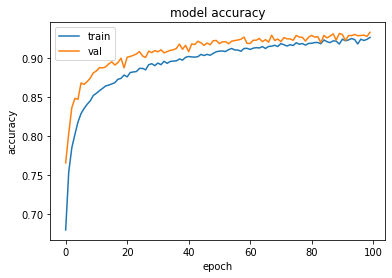

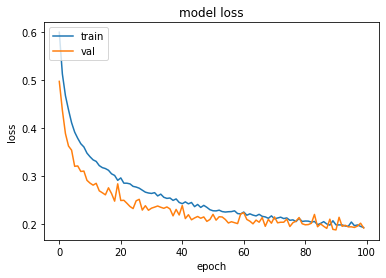

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

AUC: 0.945


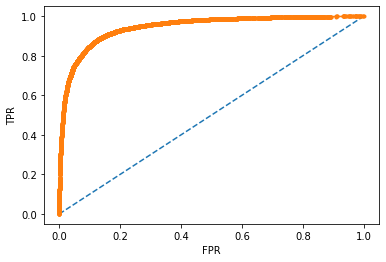

In [19]:
# Test
y_pred = model.predict(X_test)

# Check ROC, AUC
#y_test = balanced_y540
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

# Plot
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
model.save('/content/drive/MyDrive/Yoga-82/Models/mpALL77_shuffle')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Yoga-82/Models/mpALL77_shuffle/assets


In [22]:
m = load_model('/content/drive/MyDrive/Yoga-82/Models/mpALL77_shuffle')
p=m.predict(X_test)


In [23]:
p=y_pred

In [24]:
accuracy_score([int(i) for i in y_test], [int(i+0.1) for i in p])

0.8347120585427935

In [25]:
from sklearn.metrics import f1_score, classification_report

In [26]:
print(classification_report([int(i) for i in y_test],[int(i+0.1) for i in p]))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85     12572
           1       0.95      0.71      0.81     12572

    accuracy                           0.83     25144
   macro avg       0.86      0.83      0.83     25144
weighted avg       0.86      0.83      0.83     25144



In [27]:
l = len(y_train)
y_train[l//2-5:l//2+5]

array([0., 0., 1., 1., 0., 0., 0., 1., 1., 0.])

In [28]:
p

array([[9.9703395e-01],
       [9.7527111e-01],
       [9.8709619e-01],
       ...,
       [8.7811364e-05],
       [4.1782409e-01],
       [5.4854751e-03]], dtype=float32)

In [29]:
len(y_train)

57143

In [30]:
len(y_test)

25144

In [31]:
np.sum(y_test)

12572.0

In [32]:
train_test_split([1,2,3,4,5,6,7,8], [1,2,3,4,5,6,7,8], test_size=0.001, random_state=2)

[[2, 7, 3, 4, 8, 6, 1], [5], [2, 7, 3, 4, 8, 6, 1], [5]]